# Imports

In [483]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
from scipy.stats import mode
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN


# Data Sets

In [484]:
# Dataset 1 points
dataset1 = {
    'A1': (2, 10), 'A2': (2, 5), 'A3': (8, 4), 'A4': (5, 8),
    'A5': (7, 5), 'A6': (6, 4), 'A7': (1, 2), 'A8': (4, 9)
}

# Dataset 2: Load from URL
url = "https://raw.githubusercontent.com/tofighi/MachineLearning/master/datasets/heart.csv"
df = pd.read_csv(url)

# Display basic dataset information
df.info()
df=df.drop(columns=['row.names'])
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 462 entries, 0 to 461
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   row.names  462 non-null    int64  
 1   sbp        462 non-null    int64  
 2   tobacco    462 non-null    float64
 3   ldl        462 non-null    float64
 4   adiposity  462 non-null    float64
 5   famhist    462 non-null    object 
 6   typea      462 non-null    int64  
 7   obesity    462 non-null    float64
 8   alcohol    462 non-null    float64
 9   age        462 non-null    int64  
 10  chd        462 non-null    int64  
dtypes: float64(5), int64(5), object(1)
memory usage: 39.8+ KB


,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,160,12.00,5.73,23.11,Present,49,25.30,97.20,52,1
1,144,0.01,4.41,28.61,Absent,55,28.87,2.06,63,1
2,118,0.08,3.48,32.28,Present,52,29.14,3.81,46,0
3,170,7.50,6.41,38.03,Present,51,31.99,24.26,58,1
4,134,13.60,3.50,27.78,Present,60,25.99,57.34,49,1
...,...,...,...,...,...,...,...,...,...,...
457,214,0.40,5.98,31.72,Absent,64,28.45,0.00,58,0
458,182,4.20,4.41,32.10,Absent,52,28.61,18.72,52,1
459,108,3.00,1.59,15.23,Absent,40,20.09,26.64,55,0
460,118,5.40,11.61,30.79,Absent,64,27.35,23.97,40,0


# Helper Functions

In [485]:
# Helper function to calculate Euclidean distance
def euclidean_distance(point1, point2):
    return sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)

# Nearest Neighbor Clustering Algorithm
def nearest_neighbor_clustering(dataset, threshold):
    """
    Perform Nearest Neighbor clustering on the dataset.

    Parameters:
    - dataset: A dictionary of points with labels as keys and (x, y) coordinates as values.
    - threshold: The maximum distance to consider points as part of the same cluster.

    Returns:
    - clusters: A dictionary where keys are cluster IDs and values are lists of point labels.
    """
    visited = set()  # Keep track of visited points
    clusters = {}  # Store clusters
    cluster_id = 0  # Initialize cluster ID

    for point_label, point_coords in dataset.items():
        if point_label not in visited:
            # Start a new cluster
            cluster_id += 1
            clusters[cluster_id] = []
            queue = [point_label]  # Use a queue to explore neighbors

            while queue:
                current_point = queue.pop(0)
                if current_point not in visited:
                    visited.add(current_point)
                    clusters[cluster_id].append(current_point)

                    # Find neighbors within the threshold distance
                    for neighbor_label, neighbor_coords in dataset.items():
                        if neighbor_label not in visited:
                            if euclidean_distance(dataset[current_point], neighbor_coords) <= threshold:
                                queue.append(neighbor_label)

    return clusters

# Helper function to calculate intra-cluster distance
def calculate_intra_cluster_distance(dataset, clusters, centers=None):
    """
    Calculate the intra-cluster distance for a clustering result.
    For K-Means, use cluster centers. For NN and DBScan, calculate pairwise distances within clusters.
    """
    intra_distances = []
    for cluster_id, points in clusters.items():
        if centers:  # For K-Means
            center = centers[cluster_id]
            distances = [euclidean_distance(dataset[point], center) for point in points]
        else:  # For NN and DBScan
            distances = []
            for i, point1 in enumerate(points):
                for point2 in points[i + 1:]:
                    # Handle both dictionary and NumPy array datasets
                    if isinstance(dataset, dict):
                        distances.append(euclidean_distance(dataset[point1], dataset[point2]))
                    else:  # NumPy array
                        distances.append(euclidean_distance(dataset[point1], dataset[point2]))
        intra_distances.append(np.mean(distances) if distances else 0)
    return np.mean(intra_distances)

# Helper function to calculate inter-cluster distance
def calculate_inter_cluster_distance(centers):
    """
    Calculate the inter-cluster distance for a clustering result.
    """
    distances = [
        euclidean_distance(center1, center2)
        for i, center1 in enumerate(centers)
        for center2 in centers[i + 1 :]
    ]
    return np.mean(distances) if distances else 0
# DBScan Clustering Algorithm
def dbscan_clustering(dataset, epsilon, min_points):
    """
    Perform DBScan clustering on the dataset.

    Parameters:
    - dataset: A dictionary of points with labels as keys and (x, y) coordinates as values.
    - epsilon: The maximum distance between two points to be considered neighbors.
    - min_points: The minimum number of points required to form a dense region.

    Returns:
    - clusters: A dictionary where keys are cluster IDs and values are lists of point labels.
    - noise: A list of point labels classified as noise.
    """
    visited = set()  # Keep track of visited points
    clusters = {}  # Store clusters
    noise = []  # Store noise points
    cluster_id = 0  # Initialize cluster ID

    def get_neighbors(point_label):
        """Find all neighbors of a point within epsilon distance."""
        neighbors = []
        for neighbor_label, neighbor_coords in dataset.items():
            if euclidean_distance(dataset[point_label], neighbor_coords) <= epsilon:
                neighbors.append(neighbor_label)
        return neighbors

    for point_label in dataset.keys():
        if point_label not in visited:
            visited.add(point_label)
            neighbors = get_neighbors(point_label)

            if len(neighbors) < min_points:
                # Mark as noise if not enough neighbors
                noise.append(point_label)
            else:
                # Start a new cluster
                cluster_id += 1
                clusters[cluster_id] = []
                expand_cluster(point_label, neighbors, clusters[cluster_id], visited, epsilon, min_points, dataset)

    return clusters, noise

def expand_cluster(point_label, neighbors, cluster, visited, epsilon, min_points, dataset):
    """
    Expand the cluster by recursively adding density-reachable points.
    """
    cluster.append(point_label)
    i = 0
    while i < len(neighbors):
        neighbor_label = neighbors[i]
        if neighbor_label not in visited:
            visited.add(neighbor_label)
            neighbor_neighbors = [
                n for n, coords in dataset.items()
                if euclidean_distance(dataset[neighbor_label], coords) <= epsilon
            ]
            if len(neighbor_neighbors) >= min_points:
                neighbors += neighbor_neighbors  # Add neighbors of the neighbor
        if neighbor_label not in cluster:
            cluster.append(neighbor_label)
        i += 1

# Part A

## Dataset 1

In [486]:
# Initial cluster centers (seeds)
centers = {
    'Cluster1': dataset1['A2'],  # A2 = (2, 5)
    'Cluster2': dataset1['A3'],  # A3 = (8, 4)
    'Cluster3': dataset1['A8']   # A8 = (4, 9)
}

# Assign points to clusters
clusters = {'Cluster1': [], 'Cluster2': [], 'Cluster3': []}

for point_label, point_coords in dataset1.items():
    distances = {cluster: euclidean_distance(point_coords, center) for cluster, center in centers.items()}
    closest_cluster = min(distances, key=distances.get)
    clusters[closest_cluster].append(point_label)

# Calculate new cluster centers
new_centers = {}
for cluster, points in clusters.items():
    if points:  # Avoid division by zero
        x_coords = [dataset1[point][0] for point in points]
        y_coords = [dataset1[point][1] for point in points]
        new_centers[cluster] = (np.mean(x_coords), np.mean(y_coords))
    else:
        new_centers[cluster] = centers[cluster]  # Keep the old center if no points are assigned

### Q1

In [487]:
print("Q1: New Clusters")
for cluster, points in clusters.items():
    print(f"{cluster}: {points}")

Q1: New Clusters
Cluster1: ['A2', 'A7']
Cluster2: ['A3', 'A5', 'A6']
Cluster3: ['A1', 'A4', 'A8']


### Q2

In [488]:
print("\nQ2: New Cluster Centers")
for cluster, center in new_centers.items():
    # Format the coordinates to 2 decimal places
    center = tuple(f"{coord:.2f}" for coord in center)
    print(f"{cluster}: {center}")


Q2: New Cluster Centers
Cluster1: ('1.50', '3.50')
Cluster2: ('7.00', '4.33')
Cluster3: ('3.67', '9.00')


### Q3

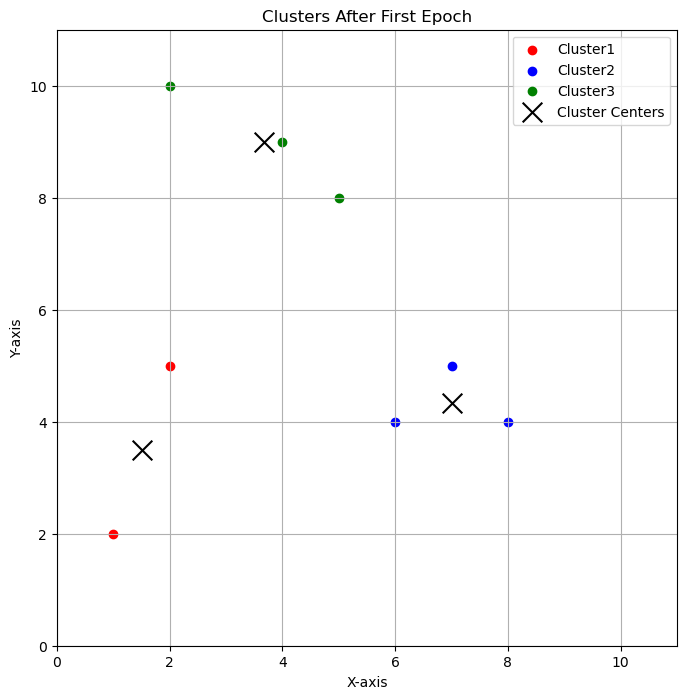

In [489]:
# Q3: Plot the clusters after the first epoch
plt.figure(figsize=(8, 8))
colors = {'Cluster1': 'red', 'Cluster2': 'blue', 'Cluster3': 'green'}

# Plot each cluster
for cluster, points in clusters.items():
    for point in points:
        plt.scatter(dataset1[point][0], dataset1[point][1], color=colors[cluster], label=cluster if point == points[0] else "")

# Plot the cluster centers (single legend entry for all centers)
for cluster, center in new_centers.items():
    plt.scatter(center[0], center[1], color='black', marker='x', s=200)

# Add a single legend entry for cluster centers
plt.scatter([], [], color='black', marker='x', s=200, label="Cluster Centers")

# Set axis limits for a 10 by 10 space
plt.xlim(0, 11)
plt.ylim(0, 11)

# Add labels, grid, and legend
plt.title("Clusters After First Epoch")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.grid(True)
plt.legend()
plt.show()

### Q4


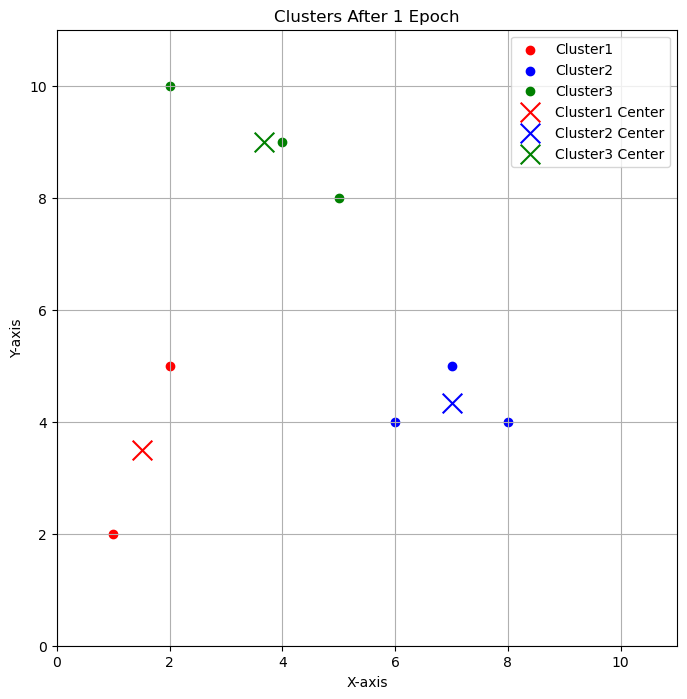

Q4: Total Iterations to Converge: 2


In [490]:
# Q4: Run K-Means until convergence
def k_means_until_convergence(dataset, initial_centers):
    """
    Perform K-Means clustering until convergence.

    Parameters:
    - dataset: A dictionary of points with labels as keys and (x, y) coordinates as values.
    - initial_centers: A dictionary of initial cluster centers with cluster names as keys and (x, y) coordinates as values.

    Returns:
    - clusters: A dictionary where keys are cluster names and values are lists of point labels assigned to each cluster.
    - centers: A dictionary of final cluster centers after convergence.
    - iterations: The total number of iterations required for convergence.
    """
    # Initialize variables
    centers = initial_centers.copy()  # Start with the initial cluster centers
    iterations = 0  # Counter to track the number of iterations

    while True:
        # Step 1: Assign points to the nearest cluster
        clusters = {cluster: [] for cluster in centers}  # Initialize empty lists for each cluster
        for point_label, point_coords in dataset.items():
            # Calculate the distance of the point to each cluster center
            distances = {cluster: euclidean_distance(point_coords, center) for cluster, center in centers.items()}
            # Assign the point to the cluster with the smallest distance
            closest_cluster = min(distances, key=distances.get)
            clusters[closest_cluster].append(point_label)

        # Step 2: Recalculate cluster centers based on the assigned points
        new_centers = {}
        for cluster, points in clusters.items():
            if points:  # If the cluster has points assigned
                # Calculate the mean of x and y coordinates of all points in the cluster
                x_coords = [dataset[point][0] for point in points]
                y_coords = [dataset[point][1] for point in points]
                new_centers[cluster] = (np.mean(x_coords), np.mean(y_coords))
            else:
                # If no points are assigned to the cluster, retain the old center
                new_centers[cluster] = centers[cluster]

        # Increment the iteration counter
        iterations += 1

        # Step 3: Check for convergence
        # Convergence occurs when the new centers are the same as the old centers
        if all(np.isclose(new_centers[cluster], centers[cluster]).all() for cluster in centers):
            break  # Exit the loop if centers do not change

        plt.figure(figsize=(8, 8))
        colors = {'Cluster1': 'red', 'Cluster2': 'blue', 'Cluster3': 'green'}

        # Plot each cluster
        for cluster, points in clusters.items():
            for point in points:
                plt.scatter(dataset1[point][0], dataset1[point][1], color=colors[cluster], label=cluster if point == points[0] else "")

        # Plot the cluster centers
        for cluster, center in new_centers.items():
            plt.scatter(center[0], center[1], color=colors[cluster], marker='x', s=200, label=f"{cluster} Center")

        # Set axis limits for a 10 by 10 space
        plt.xlim(0, 11)
        plt.ylim(0, 11)

        # Add labels, grid, and legend
        plt.title(f"Clusters After {iterations} Epoch")
        plt.xlabel("X-axis")
        plt.ylabel("Y-axis")
        plt.grid(True)
        plt.legend()
        plt.show()

        # Update the centers for the next iteration
        centers = new_centers

    # Return the final clusters, final centers, and the total number of iterations
    return clusters, centers, iterations

# Run K-Means until convergence
final_clusters, final_centers, total_iterations = k_means_until_convergence(dataset1, centers)

# Output the total number of iterations
print(f"Q4: Total Iterations to Converge: {total_iterations}")

### Q5

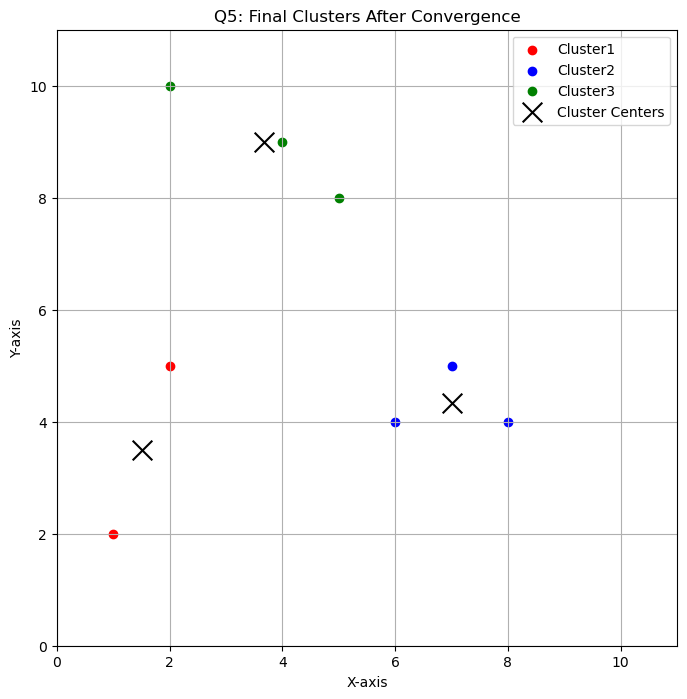

In [491]:
# Q5: Plot the final clusters after convergence
plt.figure(figsize=(8, 8))

# Plot each cluster
for cluster, points in final_clusters.items():
    for point in points:
        plt.scatter(dataset1[point][0], dataset1[point][1], color=colors[cluster], label=cluster if point == points[0] else "")

# Plot the final cluster centers (single legend entry for all centers)
for cluster, center in final_centers.items():
    plt.scatter(center[0], center[1], color='black', marker='x', s=200)

# Add a single legend entry for cluster centers
plt.scatter([], [], color='black', marker='x', s=200, label="Cluster Centers")

# Set axis limits for a 10 by 10 space
plt.xlim(0, 11)
plt.ylim(0, 11)

# Add labels, grid, and legend
plt.title("Q5: Final Clusters After Convergence")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.grid(True)
plt.legend()
plt.show()

## Dataset 2

In [492]:
# Preprocess Dataset 2
# Use only the first 300 rows for training and the rest for testing
train_data = df.iloc[:300]
test_data = df.iloc[300:]

# Select features 'sbp' and 'tobacco' for clustering
train_features = train_data[['sbp', 'tobacco']].values
test_features = test_data[['sbp', 'tobacco']].values

# Convert 'chd' (target) to numeric values for evaluation
train_labels = train_data['chd'].values
test_labels = test_data['chd'].values

# Helper function for K-Means clustering
def k_means_clustering(data, k, max_iterations=1000):
    # Randomly initialize cluster centers
    np.random.seed(42)  # For reproducibility
    centers = data[np.random.choice(data.shape[0], k, replace=False)]

    for _ in range(max_iterations):
        # Step 1: Assign points to the nearest cluster
        clusters = {i: [] for i in range(k)}
        for point in data:
            distances = [euclidean_distance(point, center) for center in centers]
            closest_cluster = np.argmin(distances)
            clusters[closest_cluster].append(point)

        # Step 2: Recalculate cluster centers
        new_centers = []
        for i in range(k):
            if clusters[i]:  # Avoid division by zero
                new_centers.append(np.mean(clusters[i], axis=0))
            else:
                new_centers.append(centers[i])  # Keep the old center if no points are assigned

        new_centers = np.array(new_centers)

        # Check for convergence
        if np.allclose(new_centers, centers):
            break
        centers = new_centers

    return clusters, centers

# Run K-Means on training data
k = 2  # Number of clusters
clusters, centers = k_means_clustering(train_features, k)

# Assign cluster labels to training data
train_predictions = np.zeros(train_features.shape[0])
for cluster_id, points in clusters.items():
    for point in points:
        index = np.where((train_features == point).all(axis=1))[0][0]
        train_predictions[index] = cluster_id

### Q6

In [493]:
# Map cluster IDs to actual labels
cluster_to_label = {}
for cluster_id, points in clusters.items():
    # Find the indices of the points in the cluster
    cluster_indices = [np.where((train_features == point).all(axis=1))[0][0] for point in points]
    # Get the corresponding labels for these points
    cluster_labels = train_labels[cluster_indices]
    # Find the most common label in the cluster
    cluster_mode = mode(cluster_labels, keepdims=True)  # Use keepdims=True for compatibility
    cluster_to_label[cluster_id] = cluster_mode.mode[0]  # Access the most common label
    print(f"Cluster {cluster_id}: {len(points)} points")
    

# Convert predictions to actual labels
mapped_predictions = np.array([cluster_to_label[int(pred)] for pred in train_predictions])

# Calculate accuracy
accuracy = np.mean(mapped_predictions == train_labels)
print(f"Q6: Training Accuracy: {100*accuracy:.2f}%")

Cluster 0: 81 points
Cluster 1: 219 points
Q6: Training Accuracy: 63.33%


### Q7


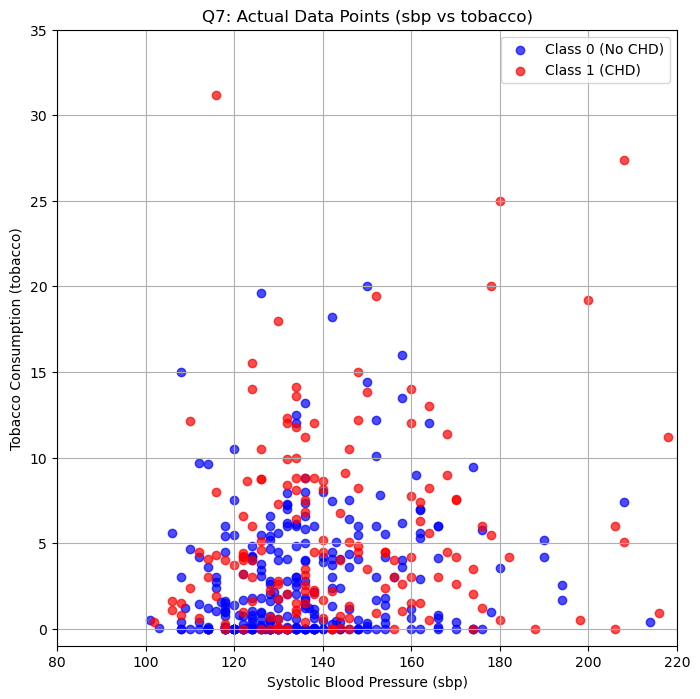

In [494]:
# Q7: Plot actual data points
# Convert 'chd' (categorical labels) to numeric values if not already numeric
df['chd'] = df['chd'].astype(int)

# Separate the two classes based on the 'chd' label
class_0 = df[df['chd'] == 0]
class_1 = df[df['chd'] == 1]

# Plot the data points
plt.figure(figsize=(8, 8))
plt.scatter(class_0['sbp'], class_0['tobacco'], color='blue', label='Class 0 (No CHD)', alpha=0.7)
plt.scatter(class_1['sbp'], class_1['tobacco'], color='red', label='Class 1 (CHD)', alpha=0.7)

# Add labels, title, and legend
plt.xlim(80, 220)
plt.ylim(-1, 35)
plt.title("Q7: Actual Data Points (sbp vs tobacco)")
plt.xlabel("Systolic Blood Pressure (sbp)")
plt.ylabel("Tobacco Consumption (tobacco)")
plt.legend()
plt.grid(True)
plt.show()

### Q8

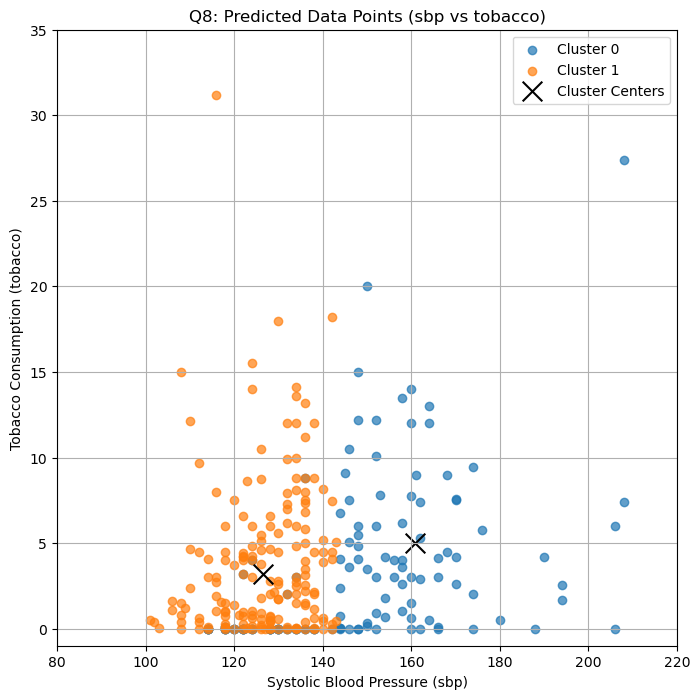

In [495]:
# Q8: Plot predicted data points
plt.figure(figsize=(8, 8))

# Separate the predicted clusters
for cluster_id in np.unique(train_predictions):
    cluster_points = train_features[train_predictions == cluster_id]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {int(cluster_id)}", alpha=0.7)

# Plot the cluster centers
for center in centers:
    plt.scatter(center[0], center[1], color='black', marker='x', s=200)

# Add a single legend entry for cluster centers
plt.scatter([], [], color='black', marker='x', s=200, label="Cluster Centers")

# Add labels, title, and legend
plt.xlim(80, 220)
plt.ylim(-1, 35)
plt.title("Q8: Predicted Data Points (sbp vs tobacco)")
plt.xlabel("Systolic Blood Pressure (sbp)")
plt.ylabel("Tobacco Consumption (tobacco)")
plt.legend()
plt.grid(True)
plt.show()

# Part B

## Dataset 1

In [496]:
# Run Nearest Neighbor Clustering on Dataset 1
threshold = 4
nn_clusters = nearest_neighbor_clustering(dataset1, threshold)

### Q9

In [497]:
# Output the clusters
print("Q9: Nearest Neighbor Clusters")
for cluster_id, points in nn_clusters.items():
    print(f"Cluster {cluster_id}: {points}")

Q9: Nearest Neighbor Clusters
Cluster 1: ['A1', 'A4', 'A8', 'A5', 'A3', 'A6']
Cluster 2: ['A2', 'A7']


### Q10

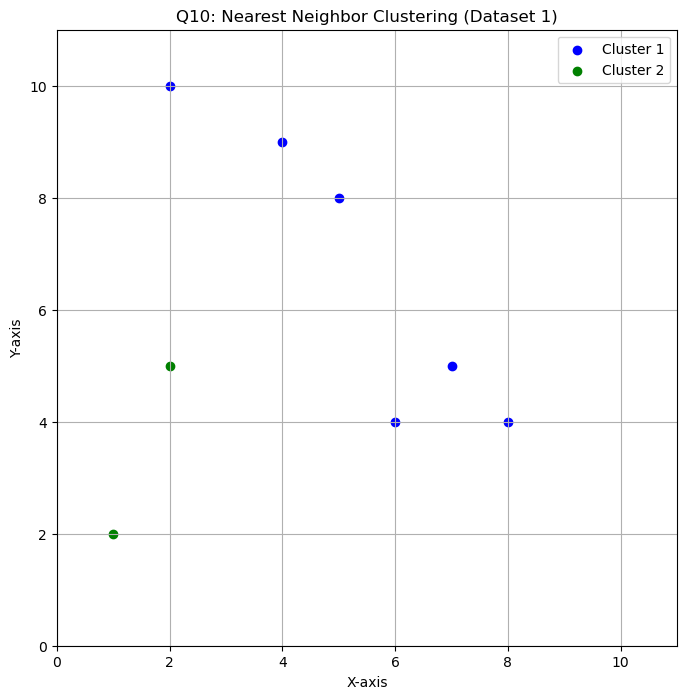

In [498]:
# Q10: Plot the final clusters for Nearest Neighbor Clustering
plt.figure(figsize=(8, 8))
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray']  # Add more colors if needed

for cluster_id, points in nn_clusters.items():
    cluster_color = colors[cluster_id % len(colors)]  # Cycle through colors
    for point in points:
        plt.scatter(dataset1[point][0], dataset1[point][1], color=cluster_color, label=f"Cluster {cluster_id}" if point == points[0] else "")

# Add labels and grid
plt.title("Q10: Nearest Neighbor Clustering (Dataset 1)")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.xlim(0, 11)
plt.ylim(0, 11)
plt.grid(True)
plt.legend()
plt.show()

### Q11

In [499]:
# Dataset 1: Numerical Comparison
# For K-Means
kmeans_intra = calculate_intra_cluster_distance(dataset1, final_clusters, final_centers)
kmeans_inter = calculate_inter_cluster_distance(list(final_centers.values()))

# For Nearest Neighbor
nn_intra = calculate_intra_cluster_distance(dataset1, nn_clusters)
# NN does not have explicit centers, so inter-cluster distance is not directly comparable

# Print results
print("Q11: Numerical Comparison")
print(f"K-Means Intra-Cluster Distance (Compactness): {kmeans_intra:.2f}")
print(f"K-Means Inter-Cluster Distance (Separation): {kmeans_inter:.2f}")
print(f"NN Intra-Cluster Distance (Compactness): {nn_intra:.2f}")

Q11: Numerical Comparison
K-Means Intra-Cluster Distance (Compactness): 1.27
K-Means Inter-Cluster Distance (Separation): 5.74
NN Intra-Cluster Distance (Compactness): 3.73


#### Disadvantages

*   K-Means
  * Sensitive to initialization of cluster centers.
  * Assumes clusters are spherical and evenly sized.
  * Struggles with non-convex clusters or clusters of varying densities.
*   Nearest Neighbour Clustering
  * Sensitive to the choice of the threshold value.
  * Computationally expensive for large datasets (due to pairwise distance calculations).
  * May result in fragmented clusters if the threshold is too small.



#### Advantages

*   K-Means
  * Works well for spherical clusters.
  * Computationally efficient for large datasets.
  * Easy to implement and interpret.
*   Nearest Neighbour Clustering
  * Does not assume a specific cluster shape.
  * Can handle clusters of varying densities and non-convex shapes.
  * Simple to implement with a distance threshold.



## Dataset 2

In [500]:
# Convert train_features (NumPy array) to a dictionary
train_features_dict = {i: tuple(train_features[i]) for i in range(train_features.shape[0])}

# Run Nearest Neighbor Clustering on Dataset 2 (Training Data)
threshold = 10  # Adjust the threshold based on the dataset
nn_clusters = nearest_neighbor_clustering(train_features_dict, threshold)

# Output the clusters
print("Nearest Neighbor Clusters (Dataset 2)")
for cluster_id, points in nn_clusters.items():
    print(f"Cluster {cluster_id}: {points}")

Nearest Neighbor Clusters (Dataset 2)
Cluster 1: [0, 18, 46, 54, 62, 99, 105, 111, 124, 129, 130, 140, 169, 183, 197, 198, 215, 247, 250, 254, 255, 273, 299, 22, 31, 52, 55, 101, 117, 118, 167, 173, 180, 181, 205, 206, 221, 248, 252, 259, 292, 3, 78, 107, 182, 293, 34, 82, 126, 150, 163, 199, 17, 27, 83, 159, 253, 256, 281, 284, 157, 237, 276, 28, 186, 29, 113, 1, 6, 41, 60, 92, 145, 190, 222, 225, 243, 257, 295, 133, 36, 63, 77, 81, 87, 116, 240, 162, 195, 220, 234, 24, 123, 155, 258, 39, 65, 96, 100, 208, 209, 223, 228, 231, 263, 269, 275, 23, 30, 61, 127, 147, 148, 194, 201, 271, 272, 216, 75, 97, 246, 297, 51, 53, 76, 95, 112, 128, 132, 134, 188, 202, 210, 214, 227, 283, 286, 287, 294, 9, 13, 213, 267, 5, 21, 131, 165, 176, 224, 264, 296, 4, 11, 298, 38, 64, 119, 193, 270, 143, 43, 71, 72, 84, 85, 115, 141, 174, 187, 196, 232, 245, 251, 235, 151, 241, 45, 120, 142, 74, 103, 137, 178, 191, 203, 156, 229, 189, 49, 57, 73, 88, 160, 168, 236, 244, 285, 33, 86, 109, 139, 172, 239, 249, 

### Q12

Cluster 1: 295 points
Cluster 2: 3 points
Cluster 3: 1 points
Cluster 4: 1 points
Q12: Nearest Neighbor Clustering Accuracy: 64.33%


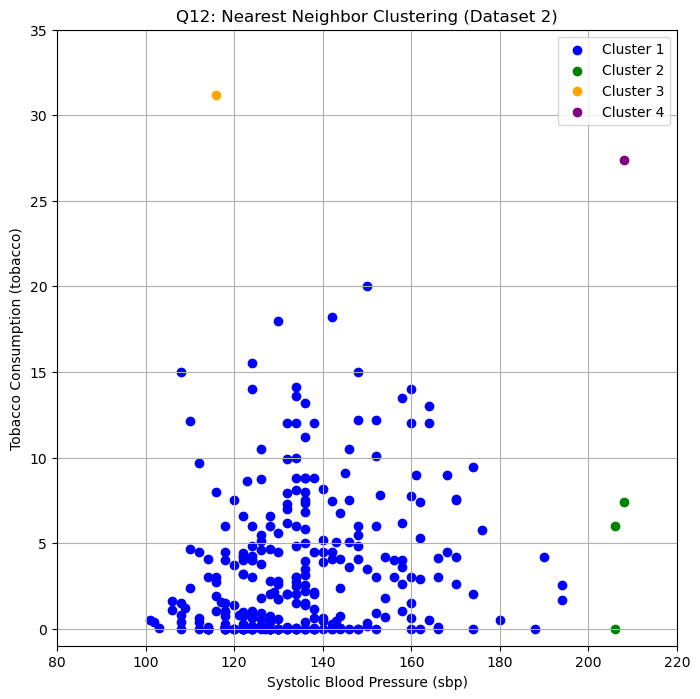

In [501]:
# Map cluster IDs to actual labels
cluster_to_label = {}
for cluster_id, points in nn_clusters.items():
    cluster_labels = train_labels[points]  # Get the labels of points in the cluster
    cluster_mode = mode(cluster_labels, keepdims=True)  # Find the most common label
    cluster_to_label[cluster_id] = cluster_mode.mode[0]  # Map cluster ID to the most common label
    # Count the number of points in each cluster
    print(f"Cluster {cluster_id}: {len(points)} points")

# Convert predictions to actual labels
nn_predictions = np.zeros(train_features.shape[0])
for cluster_id, points in nn_clusters.items():
    for point in points:
        nn_predictions[point] = cluster_to_label[cluster_id]

# Calculate accuracy
accuracy = np.mean(nn_predictions == train_labels)
print(f"Q12: Nearest Neighbor Clustering Accuracy: {100 * accuracy:.2f}%")

# Q12: Plot Nearest Neighbor Clusters
plt.figure(figsize=(8, 8))
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray']  # Add more colors if needed

# Plot each cluster
for cluster_id, points in nn_clusters.items():
    cluster_points = train_features[points]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], color=colors[cluster_id % len(colors)], label=f"Cluster {cluster_id}")

# Add labels, title, and legend
plt.xlim(80, 220)
plt.ylim(-1, 35)
plt.title("Q12: Nearest Neighbor Clustering (Dataset 2)")
plt.xlabel("Systolic Blood Pressure (sbp)")
plt.ylabel("Tobacco Consumption (tobacco)")
plt.legend()
plt.grid(True)
plt.show()

# Part C

## Dataset 1

In [502]:
# Run DBScan on Dataset 1
epsilon = 2  # Maximum distance between neighbors
min_points = 2  # Minimum number of points to form a cluster
dbscan_clusters, dbscan_noise = dbscan_clustering(dataset1, epsilon, min_points)

# Output the clusters and noise
print("DBScan Clusters (ε=2, minPoints=2)")
for cluster_id, points in dbscan_clusters.items():
    print(f"Cluster {cluster_id}: {points}")
print(f"Noise: {dbscan_noise}")

DBScan Clusters (ε=2, minPoints=2)
Cluster 1: ['A3', 'A5', 'A6']
Cluster 2: ['A4', 'A8']
Noise: ['A1', 'A2', 'A7']


### Q13

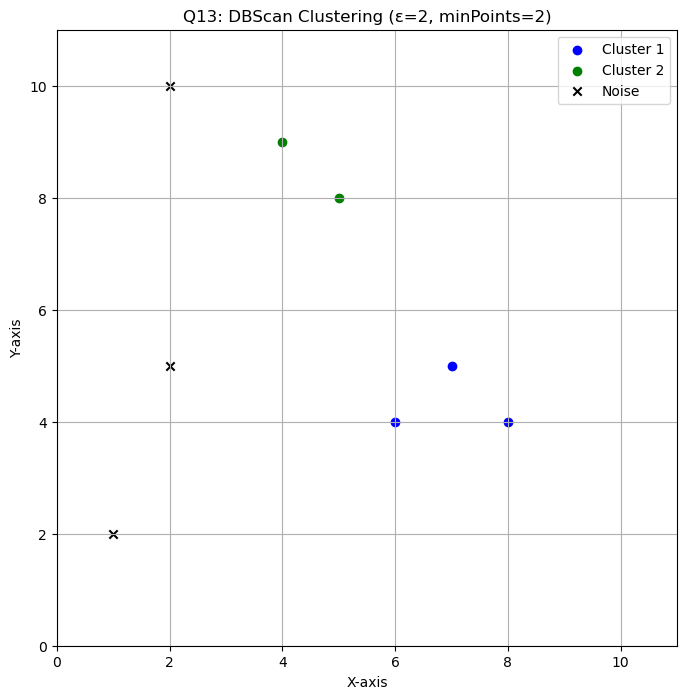

In [503]:
# Q13: Plot the DBScan Clusters
plt.figure(figsize=(8, 8))
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray']  # Add more colors if needed

# Plot clusters
for cluster_id, points in dbscan_clusters.items():
    cluster_color = colors[cluster_id % len(colors)]  # Cycle through colors
    for point in points:
        plt.scatter(dataset1[point][0], dataset1[point][1], color=cluster_color, label=f"Cluster {cluster_id}" if point == points[0] else "")

# Plot noise points
for point in dbscan_noise:
    plt.scatter(dataset1[point][0], dataset1[point][1], color='black', marker='x', label="Noise" if point == dbscan_noise[0] else "")

# Add labels and grid
plt.title("Q13: DBScan Clustering (ε=2, minPoints=2)")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.xlim(0, 11)
plt.ylim(0, 11)
plt.grid(True)
plt.legend()
plt.show()

### Q14

Q14: DBScan Clusters (ε=√10, minPoints=2)
Cluster 1: ['A1', 'A8', 'A4']
Cluster 2: ['A2', 'A7']
Cluster 3: ['A3', 'A5', 'A6']
Noise: []


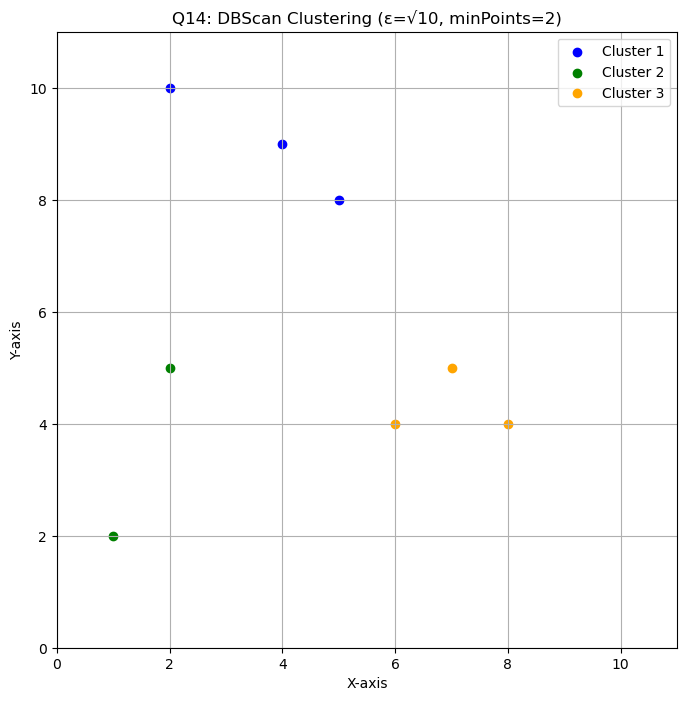

In [504]:
# Run DBScan with ε=√10
epsilon = np.sqrt(10)  # Maximum distance between neighbors
dbscan_clusters_sqrt10, dbscan_noise_sqrt10 = dbscan_clustering(dataset1, epsilon, min_points)

# Output the clusters and noise
print("Q14: DBScan Clusters (ε=√10, minPoints=2)")
for cluster_id, points in dbscan_clusters_sqrt10.items():
    print(f"Cluster {cluster_id}: {points}")
print(f"Noise: {dbscan_noise_sqrt10}")

# Plot the clusters
plt.figure(figsize=(8, 8))

# Plot clusters
for cluster_id, points in dbscan_clusters_sqrt10.items():
    cluster_color = colors[cluster_id % len(colors)]  # Cycle through colors
    for point in points:
        plt.scatter(dataset1[point][0], dataset1[point][1], color=cluster_color, label=f"Cluster {cluster_id}" if point == points[0] else "")

# Plot noise points
for point in dbscan_noise_sqrt10:
    plt.scatter(dataset1[point][0], dataset1[point][1], color='black', marker='x', label="Noise" if point == dbscan_noise_sqrt10[0] else "")

# Add labels and grid
plt.title("Q14: DBScan Clustering (ε=√10, minPoints=2)")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.xlim(0, 11)
plt.ylim(0, 11)
plt.grid(True)
plt.legend()
plt.show()

## Dataset 2

In [505]:
# Run DBScan on Dataset 2 (Training Data)
epsilon = 10  # Adjust epsilon based on the dataset
min_points = 5  # Minimum number of points to form a cluster
dbscan_clusters, dbscan_noise = dbscan_clustering(train_features_dict, epsilon, min_points)

# Output the clusters and noise
print("DBScan Clusters (Dataset 2)")
for cluster_id, points in dbscan_clusters.items():
    print(f"Cluster {cluster_id}: {points}")
print(f"Noise: {dbscan_noise}")

DBScan Clusters (Dataset 2)
Cluster 1: [0, 18, 46, 54, 62, 99, 105, 111, 124, 129, 130, 140, 169, 183, 197, 198, 215, 247, 250, 254, 255, 273, 299, 22, 31, 52, 55, 101, 117, 118, 167, 173, 180, 181, 205, 206, 221, 248, 252, 259, 292, 3, 78, 107, 182, 293, 34, 82, 126, 150, 163, 199, 17, 27, 83, 159, 253, 256, 281, 284, 157, 237, 276, 28, 186, 29, 113, 1, 6, 41, 60, 92, 145, 190, 222, 225, 243, 257, 295, 133, 36, 63, 77, 81, 87, 116, 240, 162, 195, 220, 234, 24, 123, 155, 258, 39, 65, 96, 100, 208, 209, 223, 228, 231, 263, 269, 275, 23, 30, 61, 127, 147, 148, 194, 201, 271, 272, 216, 75, 97, 246, 297, 51, 53, 76, 95, 112, 128, 132, 134, 188, 202, 210, 214, 227, 283, 286, 287, 294, 9, 13, 213, 267, 5, 21, 131, 165, 176, 224, 264, 296, 4, 11, 298, 38, 64, 119, 193, 270, 143, 43, 71, 72, 84, 85, 115, 141, 174, 187, 196, 232, 245, 251, 235, 151, 241, 45, 120, 142, 74, 103, 137, 178, 191, 203, 156, 229, 189, 49, 57, 73, 88, 160, 168, 236, 244, 285, 33, 86, 109, 139, 172, 239, 249, 25, 50, 66

### Q15

Q15: DBScan Clustering Accuracy: 64.07%
Cluster 1: 295 points


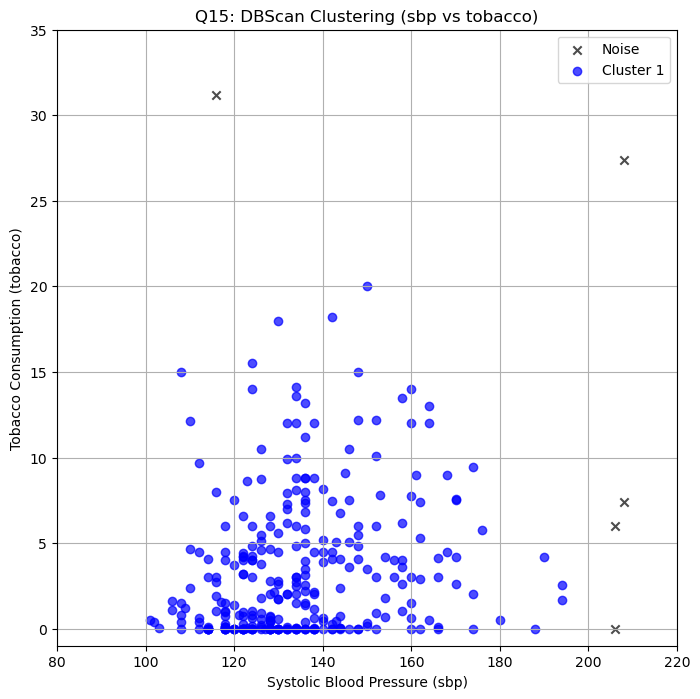

In [506]:
# Map cluster IDs to actual labels
cluster_to_label = {}
for cluster_id, points in dbscan_clusters.items():
    cluster_labels = train_labels[points]  # Get the labels of points in the cluster
    cluster_mode = mode(cluster_labels, keepdims=True)  # Find the most common label
    cluster_to_label[cluster_id] = cluster_mode.mode[0]  # Map cluster ID to the most common label

# Convert predictions to actual labels
dbscan_predictions = np.zeros(train_features.shape[0])
for cluster_id, points in dbscan_clusters.items():
    for point in points:
        dbscan_predictions[point] = cluster_to_label[cluster_id]

# Calculate accuracy (exclude noise points)
# Exclude noise points from accuracy calculation
valid_indices = np.isin(range(len(train_labels)), [point for points in dbscan_clusters.values() for point in points])
accuracy = np.mean(dbscan_predictions[valid_indices] == train_labels[valid_indices]) * 100
print(f"Q15: DBScan Clustering Accuracy: {accuracy:.2f}%")

# Plot DBScan Clusters
plt.figure(figsize=(8, 8))
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray']  # Add more colors if needed

# Plot noise points
noise_points = train_features[dbscan_noise]
plt.scatter(noise_points[:, 0], noise_points[:, 1], color='black', marker='x', label="Noise", alpha=0.7)

# Plot clusters
for cluster_id, points in dbscan_clusters.items():
    cluster_color = colors[cluster_id % len(colors)]  # Cycle through colors
    cluster_points = train_features[points]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], color=cluster_color, label=f"Cluster {cluster_id}", alpha=0.7)
    # Count the number of points in each cluster
    print(f"Cluster {cluster_id}: {len(points)} points")

# Add labels, title, and legend
plt.xlim(80, 220)
plt.ylim(-1, 35)
plt.title("Q15: DBScan Clustering (sbp vs tobacco)")
plt.xlabel("Systolic Blood Pressure (sbp)")
plt.ylabel("Tobacco Consumption (tobacco)")
plt.legend()
plt.grid(True)
plt.show()

In [507]:
# Create a mapping from keys to indices in dataset1
key_to_index = {key: i for i, key in enumerate(dataset1.keys())}
index_to_key = {i: key for key, i in key_to_index.items()}

# Map indices in nn_clusters back to keys in dataset1
nn_clusters_mapped = {
    cluster_id: [index_to_key[point] for point in points if point in index_to_key]
    for cluster_id, points in nn_clusters.items()
}

# Map indices in dbscan_clusters back to keys in dataset1
dbscan_clusters_mapped = {
    cluster_id: [index_to_key[point] for point in points if point in index_to_key]
    for cluster_id, points in dbscan_clusters.items()
}

# Dataset 1: K-Means
kmeans_intra = calculate_intra_cluster_distance(dataset1, final_clusters, final_centers)
kmeans_inter = calculate_inter_cluster_distance(list(final_centers.values()))

# Dataset 1: Nearest Neighbor
nn_intra = calculate_intra_cluster_distance(dataset1, nn_clusters_mapped)

# Dataset 1: DBScan
dbscan_intra = calculate_intra_cluster_distance(dataset1, dbscan_clusters_mapped)
dbscan_noise_count = len(dbscan_noise)

# Print results for Dataset 1
print("Dataset 1: Clustering Performance")
print(f"K-Means Intra-Cluster Distance (Compactness): {kmeans_intra:.2f}")
print(f"K-Means Inter-Cluster Distance (Separation): {kmeans_inter:.2f}")
print(f"NN Intra-Cluster Distance (Compactness): {nn_intra:.2f}")
print(f"DBScan Intra-Cluster Distance (Compactness): {dbscan_intra:.2f}")

Dataset 1: Clustering Performance
K-Means Intra-Cluster Distance (Compactness): 1.27
K-Means Inter-Cluster Distance (Separation): 5.74
NN Intra-Cluster Distance (Compactness): 1.24
DBScan Intra-Cluster Distance (Compactness): 4.95


In [508]:
def calculate_intra_cluster_distance(dataset, clusters, centers=None):
    """
    Calculate the intra-cluster distance for a clustering result.
    For K-Means, use cluster centers. For NN and DBScan, calculate pairwise distances within clusters.
    """
    intra_distances = []
    for cluster_id, points in clusters.items():
        if centers is not None:  # Explicitly check if centers is provided
            center = centers[cluster_id]
            # Iterate through the points in the cluster directly
            distances = [euclidean_distance(point, center) for point in points]  # Modified to use points directly
        else:  # For NN and DBScan
            distances = []
            # Iterate through the indices of the points in the cluster
            for i in range(len(points)):
                for j in range(i + 1, len(points)):
                    distances.append(euclidean_distance(dataset[points[i]], dataset[points[j]])) # Modified to dataset[points[i]]
        intra_distances.append(np.mean(distances) if distances else 0)
    return np.mean(intra_distances)

In [509]:
# Dataset 2: K-Means
kmeans_intra = calculate_intra_cluster_distance(train_features, clusters, centers)
kmeans_accuracy = np.mean(mapped_predictions == train_labels) * 100

# Dataset 2: Nearest Neighbor
nn_intra = calculate_intra_cluster_distance(train_features, nn_clusters)
nn_accuracy = np.mean(nn_predictions == train_labels) * 100

# Dataset 2: DBScan
dbscan_intra = calculate_intra_cluster_distance(train_features_dict, dbscan_clusters)
dbscan_noise_count = len(dbscan_noise)
dbscan_accuracy = np.mean(dbscan_predictions[valid_indices] == train_labels[valid_indices]) * 100

# Print results for Dataset 2
print("\nDataset 2: Clustering Performance")
print(f"K-Means Intra-Cluster Distance (Compactness): {kmeans_intra:.2f}")
print(f"K-Means Accuracy: {kmeans_accuracy:.2f}%")
print(f"NN Intra-Cluster Distance (Compactness): {nn_intra:.2f}")
print(f"NN Accuracy: {nn_accuracy:.2f}%")
print(f"DBScan Intra-Cluster Distance (Compactness): {dbscan_intra:.2f}")
print(f"DBScan Noise Points: {dbscan_noise_count}")
print(f"DBScan Accuracy: {dbscan_accuracy:.2f}%")


Dataset 2: Clustering Performance
K-Means Intra-Cluster Distance (Compactness): 10.92
K-Means Accuracy: 63.33%
NN Intra-Cluster Distance (Compactness): 6.42
NN Accuracy: 64.33%
DBScan Intra-Cluster Distance (Compactness): 20.32
DBScan Noise Points: 5
DBScan Accuracy: 64.07%


# Part D

## Dataset 1

In [510]:
# Convert Dataset 1 to NumPy array
dataset1_points = np.array(list(dataset1.values()))
dataset1_labels = np.array(list(dataset1.keys()))  # Optional: Keep labels for reference

### K-Means

Scikit-Learn K-Means Clustering Results:
Cluster 0: ['A3' 'A5' 'A6']
Cluster 1: ['A1' 'A4' 'A8']
Cluster 2: ['A2' 'A7']


c:\Users\jazza\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


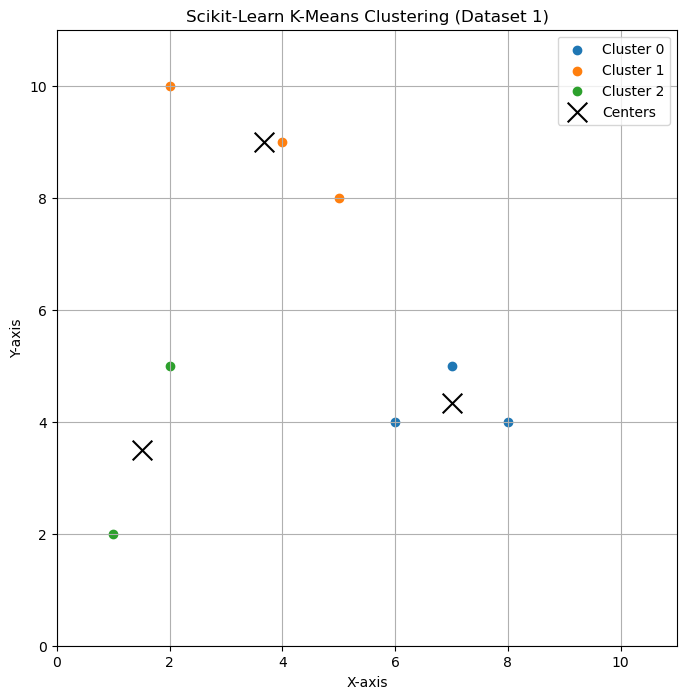

In [511]:
# Run K-Means with 3 clusters (same as Part A)
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(dataset1_points)

# Output K-Means results
print("Scikit-Learn K-Means Clustering Results:")
for cluster_id in np.unique(kmeans_labels):
    cluster_points = dataset1_labels[kmeans_labels == cluster_id]
    print(f"Cluster {cluster_id}: {cluster_points}")

# Plot K-Means Clustering Results
##SKLearn
plt.figure(figsize=(8, 8))
for cluster_id in np.unique(kmeans_labels):
    cluster_points = dataset1_points[kmeans_labels == cluster_id]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster_id}")
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], color='black', marker='x', s=200, label="Centers")
plt.xlim(0, 11)
plt.ylim(0, 11)
plt.title("Scikit-Learn K-Means Clustering (Dataset 1)")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.legend()
plt.grid(True)
plt.show()

### Nearest Neighbour


Scikit-Learn Nearest Neighbor Clustering Results:
Cluster 0: ['A1' 'A3' 'A4' 'A5' 'A6' 'A8']
Cluster 1: ['A2' 'A7']


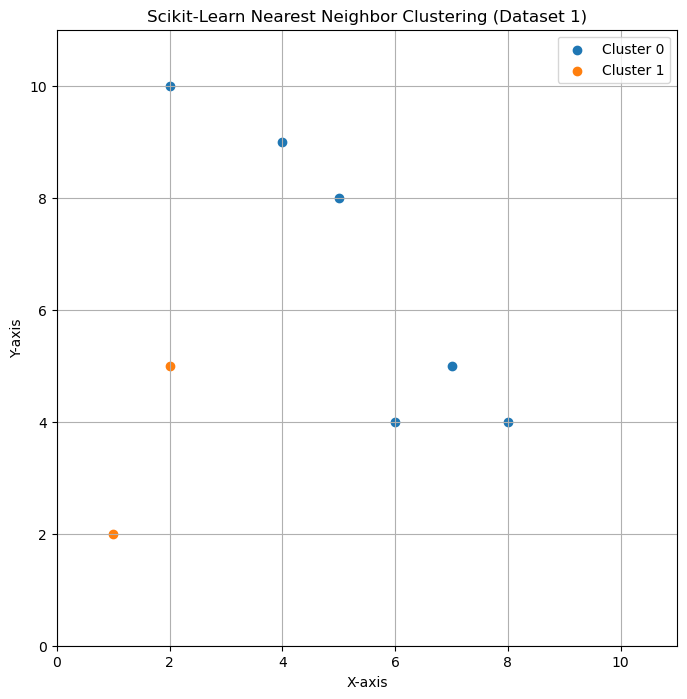

In [512]:
# Run Agglomerative Clustering with a distance threshold of 4 (same as Part B)
nn_clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=4, linkage='single')
nn_labels = nn_clustering.fit_predict(dataset1_points)

# Output Nearest Neighbor results
print("\nScikit-Learn Nearest Neighbor Clustering Results:")
for cluster_id in np.unique(nn_labels):
    cluster_points = dataset1_labels[nn_labels == cluster_id]
    print(f"Cluster {cluster_id}: {cluster_points}")

# Plot Nearest Neighbor Clustering Results
plt.figure(figsize=(8, 8))
for cluster_id in np.unique(nn_labels):
    cluster_points = dataset1_points[nn_labels == cluster_id]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster_id}")
plt.xlim(0, 11)
plt.ylim(0, 11)
plt.title("Scikit-Learn Nearest Neighbor Clustering (Dataset 1)")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.legend()
plt.grid(True)
plt.show()

### DBScan


Scikit-Learn DBScan Clustering Results:
Noise: ['A1' 'A2' 'A7']
Cluster 0: ['A3' 'A5' 'A6']
Cluster 1: ['A4' 'A8']


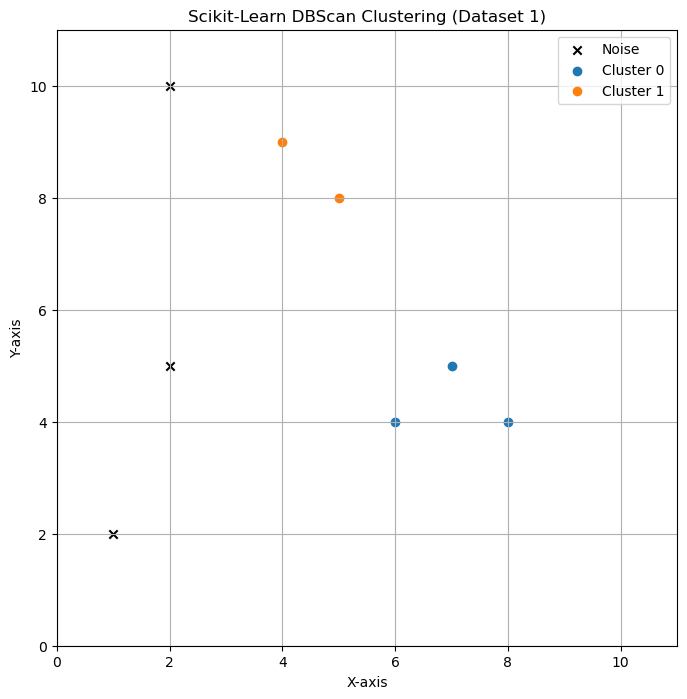

In [513]:
# Run DBScan with ε=2 and min_samples=2 (same as Part C)
dbscan = DBSCAN(eps=2, min_samples=2)
dbscan_labels = dbscan.fit_predict(dataset1_points)

# Output DBScan results
print("\nScikit-Learn DBScan Clustering Results:")
for cluster_id in np.unique(dbscan_labels):
    if cluster_id == -1:
        print(f"Noise: {dataset1_labels[dbscan_labels == cluster_id]}")
    else:
        cluster_points = dataset1_labels[dbscan_labels == cluster_id]
        print(f"Cluster {cluster_id}: {cluster_points}")

# Plot DBScan Clustering Results
plt.figure(figsize=(8, 8))
for cluster_id in np.unique(dbscan_labels):
    if cluster_id == -1:
        noise_points = dataset1_points[dbscan_labels == cluster_id]
        plt.scatter(noise_points[:, 0], noise_points[:, 1], color='black', marker='x', label="Noise")
    else:
        cluster_points = dataset1_points[dbscan_labels == cluster_id]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster_id}")
plt.xlim(0, 11)
plt.ylim(0, 11)
plt.title("Scikit-Learn DBScan Clustering (Dataset 1)")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.legend()
plt.grid(True)
plt.show()

## Dataset 2

### K-Means

Scikit-Learn K-Means Clustering Results:
Cluster 0: 226 points
Cluster 1: 74 points
K-Means Accuracy: 63.33%


c:\Users\jazza\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


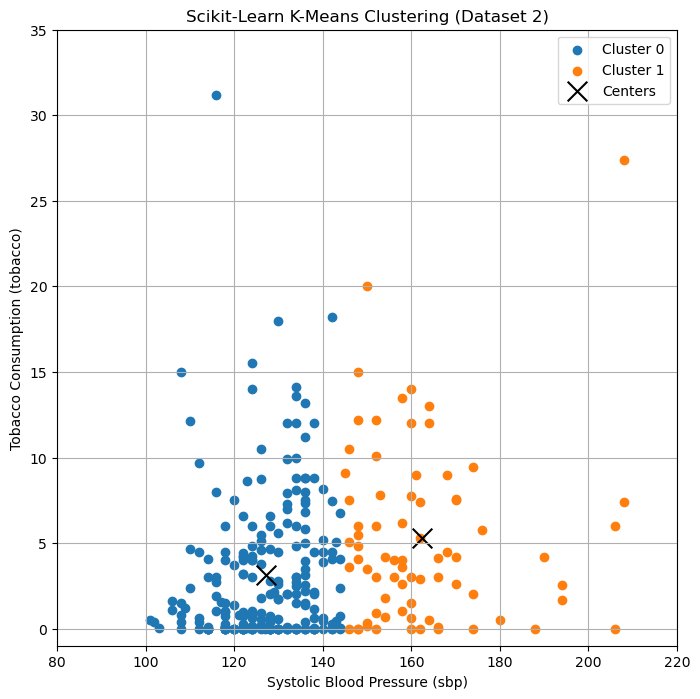

In [514]:
# Run K-Means with 2 clusters (since chd has 2 classes)
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(train_features)

# Output K-Means results
print("Scikit-Learn K-Means Clustering Results:")
for cluster_id in np.unique(kmeans_labels):
    cluster_points = train_features[kmeans_labels == cluster_id]
    print(f"Cluster {cluster_id}: {len(cluster_points)} points")

# Map cluster IDs to actual labels
cluster_to_label = {}
for cluster_id in np.unique(kmeans_labels):
    cluster_indices = np.where(kmeans_labels == cluster_id)[0]
    cluster_labels = train_labels[cluster_indices]
    # Get the mode, handling the case where it's a scalar
    mode_result = mode(cluster_labels)
    cluster_to_label[cluster_id] = mode_result.mode[0] if isinstance(mode_result.mode, np.ndarray) else mode_result.mode

# Convert predictions to actual labels
kmeans_predictions = np.array([cluster_to_label[label] for label in kmeans_labels])

# Calculate accuracy
kmeans_accuracy = np.mean(kmeans_predictions == train_labels) * 100
print(f"K-Means Accuracy: {kmeans_accuracy:.2f}%")

# Plot K-Means Clustering Results
plt.figure(figsize=(8, 8))
for cluster_id in np.unique(kmeans_labels):
    cluster_points = train_features[kmeans_labels == cluster_id]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster_id}")
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], color='black', marker='x', s=200, label="Centers")
plt.xlim(80, 220)
plt.ylim(-1, 35)
plt.title("Scikit-Learn K-Means Clustering (Dataset 2)")
plt.xlabel("Systolic Blood Pressure (sbp)")
plt.ylabel("Tobacco Consumption (tobacco)")
plt.legend()
plt.grid(True)
plt.show()

### Nearest Neighbour


Scikit-Learn Nearest Neighbor Clustering Results:
Cluster 0: 295 points
Cluster 1: 3 points
Cluster 2: 1 points
Cluster 3: 1 points
Nearest Neighbor Accuracy: 64.33%


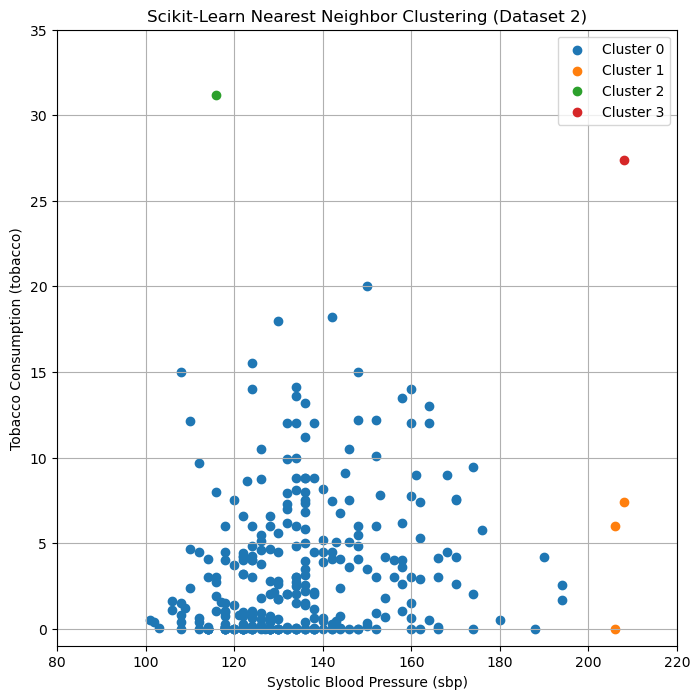

In [515]:
# Run Agglomerative Clustering with a distance threshold of 10
nn_clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=10, linkage='single')
nn_labels = nn_clustering.fit_predict(train_features)

# Output Nearest Neighbor results
print("\nScikit-Learn Nearest Neighbor Clustering Results:")
for cluster_id in np.unique(nn_labels):
    cluster_points = train_features[nn_labels == cluster_id]
    print(f"Cluster {cluster_id}: {len(cluster_points)} points")

# Map cluster IDs to actual labels
cluster_to_label = {}
for cluster_id in np.unique(nn_labels):
    cluster_indices = np.where(nn_labels == cluster_id)[0]
    cluster_labels = train_labels[cluster_indices]
    # Get the mode, handling the case where it's a scalar
    mode_result = mode(cluster_labels)
    cluster_to_label[cluster_id] = mode_result.mode[0] if isinstance(mode_result.mode, np.ndarray) else mode_result.mode

# Convert predictions to actual labels
nn_predictions = np.array([cluster_to_label[label] for label in nn_labels])

# Calculate accuracy
nn_accuracy = np.mean(nn_predictions == train_labels) * 100
print(f"Nearest Neighbor Accuracy: {nn_accuracy:.2f}%")

# Plot Nearest Neighbor Clustering Results
plt.figure(figsize=(8, 8))
for cluster_id in np.unique(nn_labels):
    cluster_points = train_features[nn_labels == cluster_id]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster_id}")
plt.xlim(80, 220)
plt.ylim(-1, 35)
plt.title("Scikit-Learn Nearest Neighbor Clustering (Dataset 2)")
plt.xlabel("Systolic Blood Pressure (sbp)")
plt.ylabel("Tobacco Consumption (tobacco)")
plt.legend()
plt.grid(True)
plt.show()

### DBScan


Scikit-Learn DBScan Clustering Results:
Noise: 5 points
Cluster 0: 295 points
DBScan Accuracy: 64.07%


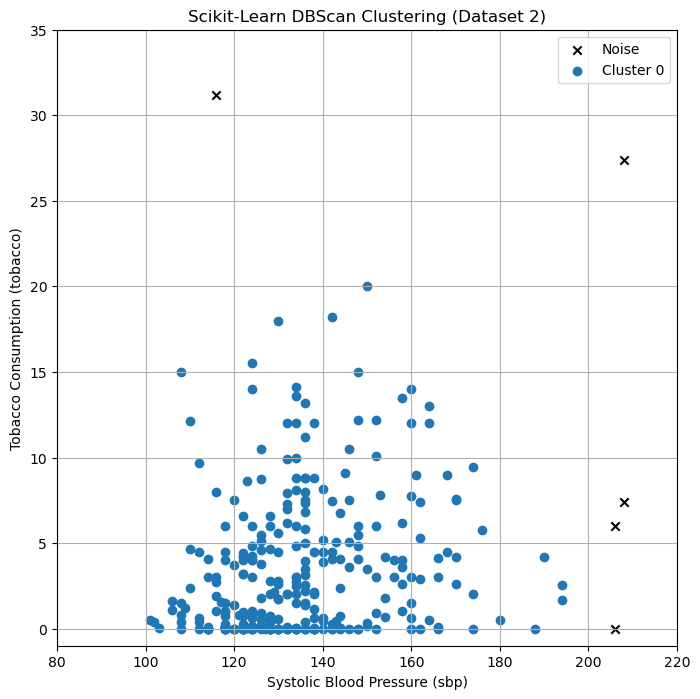

In [516]:
# Run DBScan with ε=10 and min_samples=5
dbscan = DBSCAN(eps=10, min_samples=5)
dbscan_labels = dbscan.fit_predict(train_features)

# Output DBScan results
print("\nScikit-Learn DBScan Clustering Results:")
for cluster_id in np.unique(dbscan_labels):
    if cluster_id == -1:
        print(f"Noise: {len(train_features[dbscan_labels == cluster_id])} points")
    else:
        cluster_points = train_features[dbscan_labels == cluster_id]
        print(f"Cluster {cluster_id}: {len(cluster_points)} points")

# Map cluster IDs to actual labels
cluster_to_label = {}
for cluster_id in np.unique(dbscan_labels):
    if cluster_id != -1:  # Ignore noise
        cluster_indices = np.where(dbscan_labels == cluster_id)[0]
        cluster_labels = train_labels[cluster_indices]
        # Get the mode, handling the case where it's a scalar
        mode_result = mode(cluster_labels)
        cluster_to_label[cluster_id] = mode_result.mode[0] if isinstance(mode_result.mode, np.ndarray) else mode_result.mode

# Convert predictions to actual labels (ignore noise points)
dbscan_predictions = np.array([
    cluster_to_label[label] if label != -1 else -1 for label in dbscan_labels
])

# Calculate accuracy (exclude noise points)
valid_indices = dbscan_labels != -1
dbscan_accuracy = np.mean(dbscan_predictions[valid_indices] == train_labels[valid_indices]) * 100
print(f"DBScan Accuracy: {dbscan_accuracy:.2f}%")

# Plot DBScan Clustering Results
plt.figure(figsize=(8, 8))
for cluster_id in np.unique(dbscan_labels):
    if cluster_id == -1:
        noise_points = train_features[dbscan_labels == cluster_id]
        plt.scatter(noise_points[:, 0], noise_points[:, 1], color='black', marker='x', label="Noise")
    else:
        cluster_points = train_features[dbscan_labels == cluster_id]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster_id}")
plt.xlim(80, 220)
plt.ylim(-1, 35)
plt.title("Scikit-Learn DBScan Clustering (Dataset 2)")
plt.xlabel("Systolic Blood Pressure (sbp)")
plt.ylabel("Tobacco Consumption (tobacco)")
plt.legend()
plt.grid(True)
plt.show()

## Q16

### Part A:

#### Dataset 1:

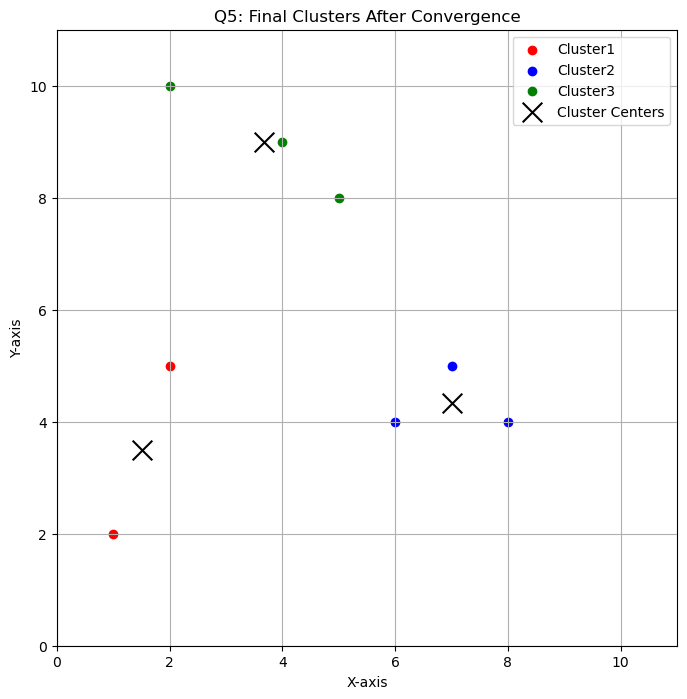
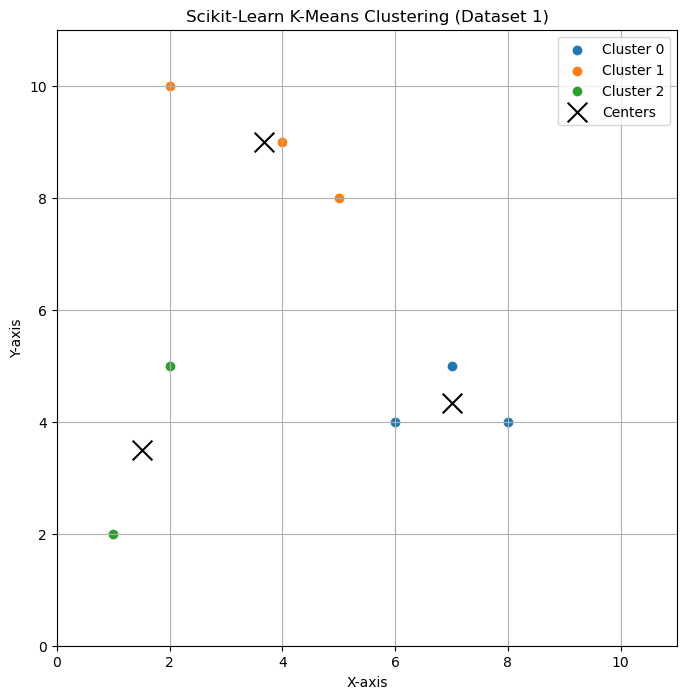

#### Dataset 2:

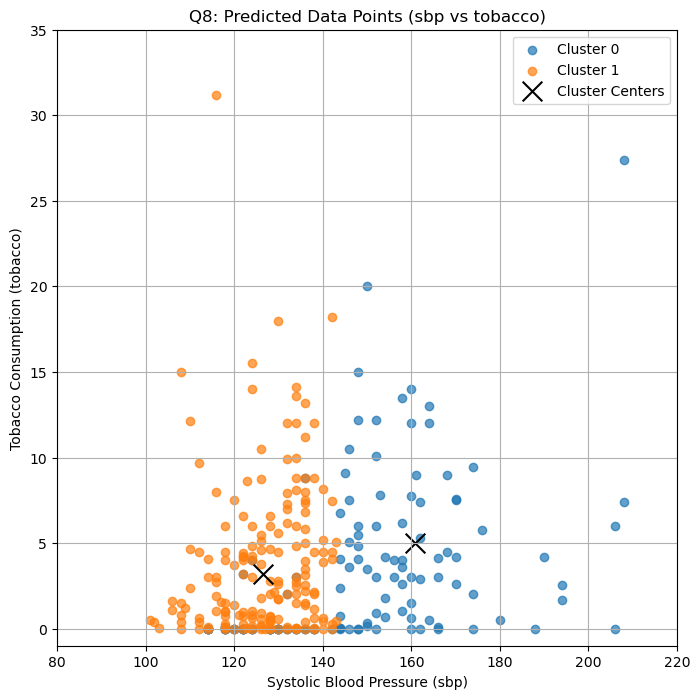
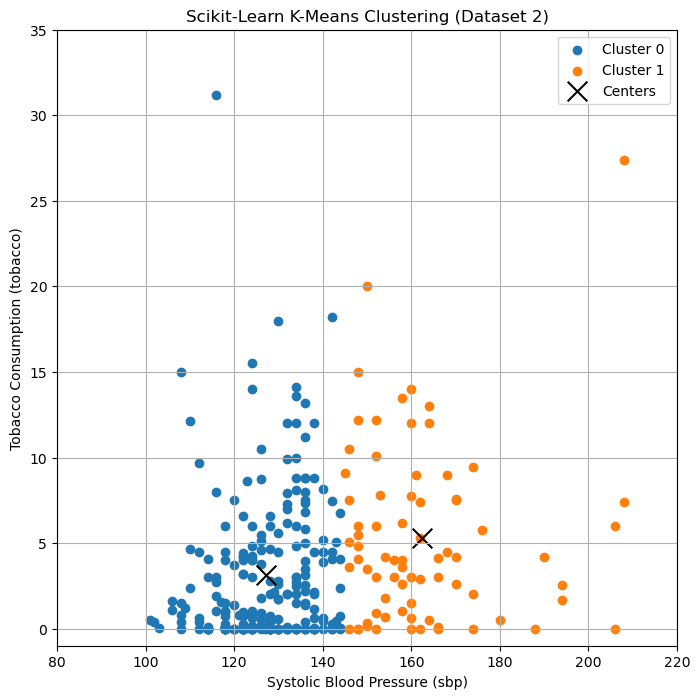

### Part B:

#### Dataset 1:

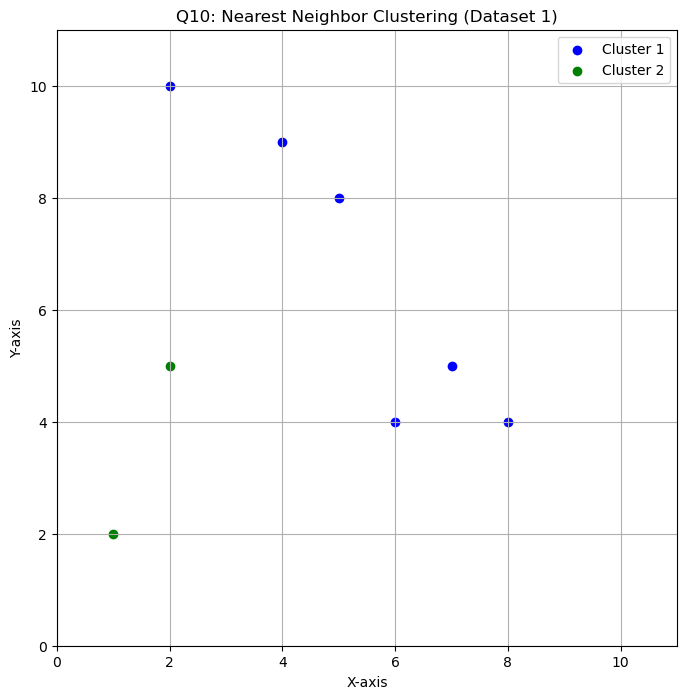
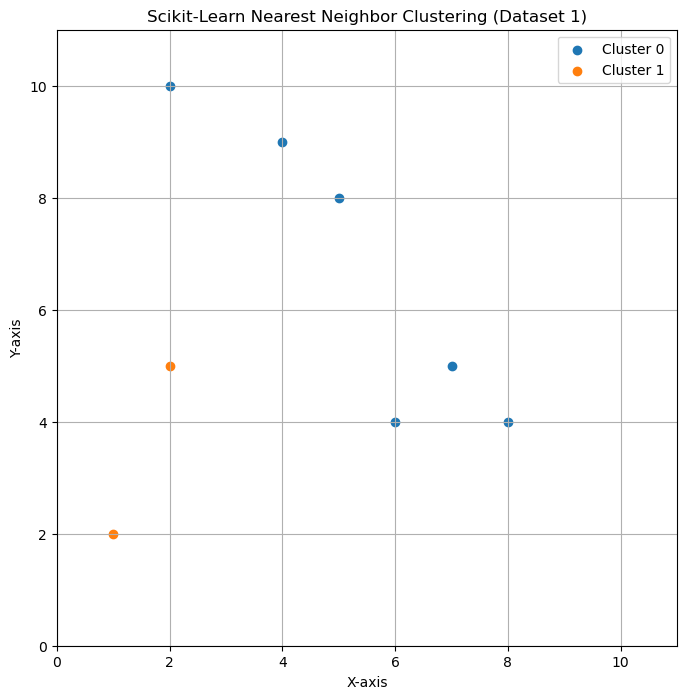

#### Dataset 2:

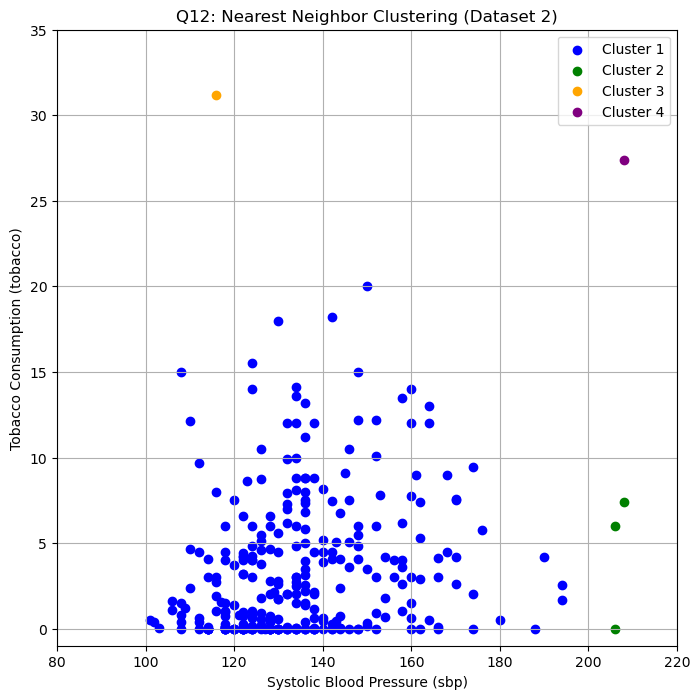
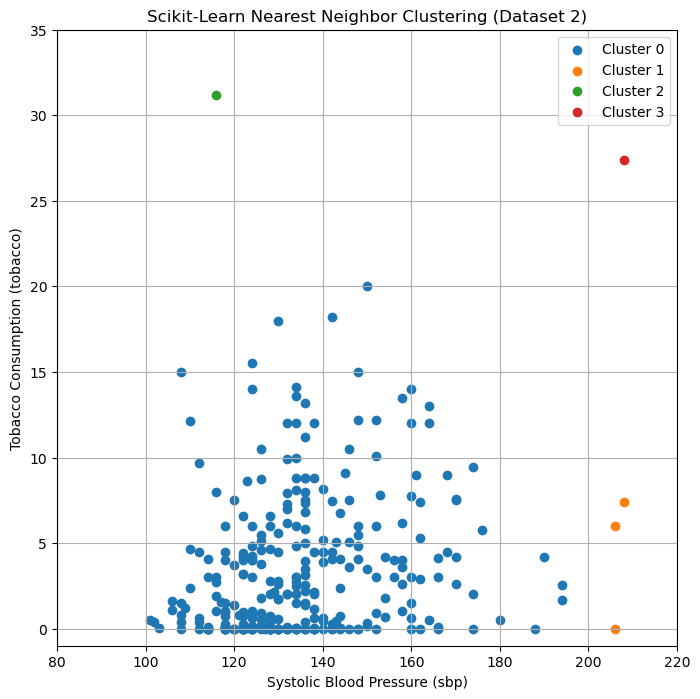

### Part C:

#### Dataset 1:

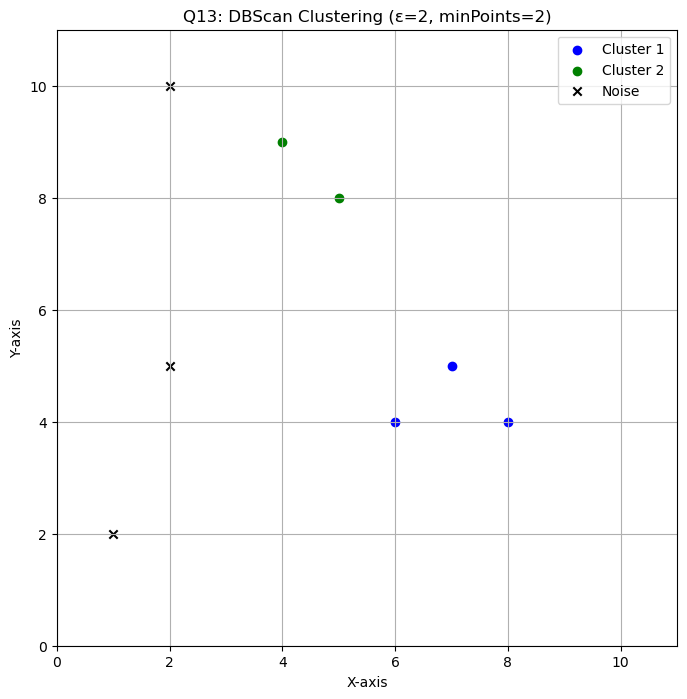
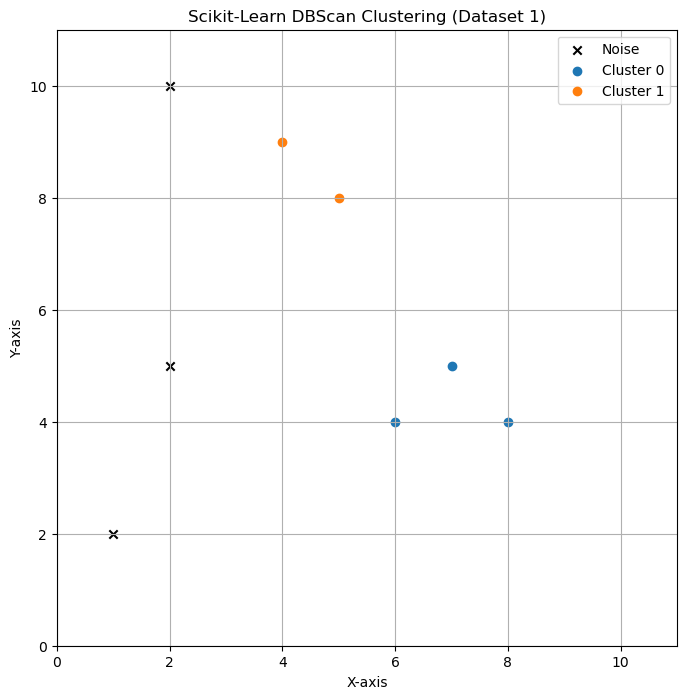

#### Dataset 2:

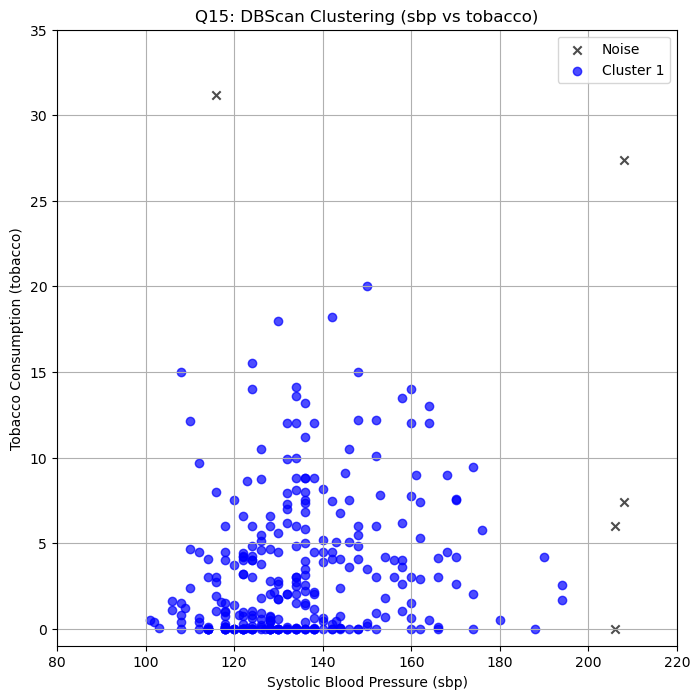
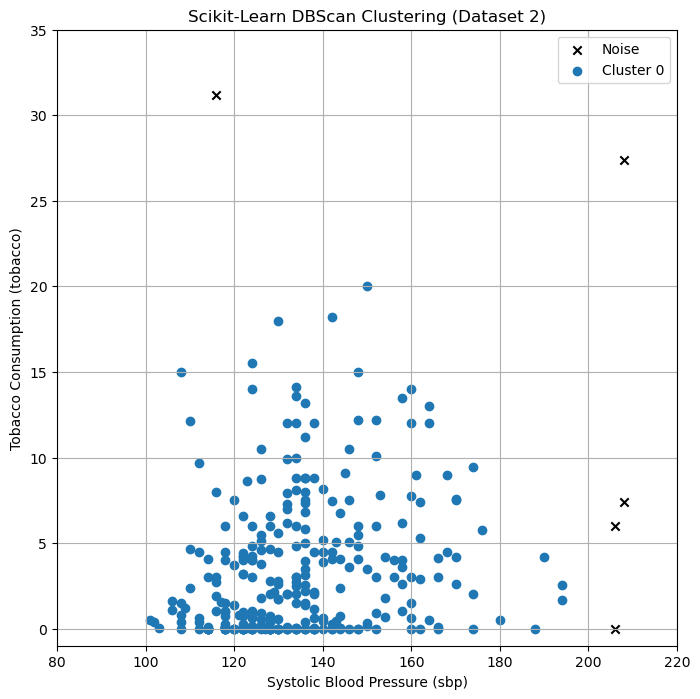

### Comments

The use of scikit-learn verified the results by providing a standardized implementation of clustering algorithms, which allowed the comparison of the custom implementations with well-tested and widely-used methods.
1. **K-Means Clustering**:
    - Scikit-learn's `KMeans` algorithm was used to cluster the data.
    - The cluster assignments and centers from scikit-learn were compared to your custom implementation.
    - Matching results (e.g., cluster assignments, centers, and convergence behavior) validated the correctness of your implementation.

2. **Nearest Neighbor Clustering**:
    - Scikit-learn's `AgglomerativeClustering` with single linkage and a distance threshold was used to replicate your nearest neighbor clustering.
    - The clusters formed by scikit-learn were compared to your custom nearest neighbor clustering results.
    - Similar clusters confirmed the accuracy of your custom algorithm.

3. **DBSCAN Clustering**:
    - Scikit-learn's `DBSCAN` algorithm was used to cluster the data with the same parameters (e.g., `eps` and `min_samples`) as your custom implementation.
    - The clusters and noise points identified by scikit-learn were compared to your custom DBSCAN results.
    - Matching clusters and noise points validated your implementation.

# Questions

# 1)

- **Intra-Cluster Distance (Compactness)**: Measures the average distance between points within the same cluster. Lower values indicate better compactness.
- **Inter-Cluster Distance (Separation)**: Measures the distance between cluster centers. Higher values indicate better separation.

# 2)

- **Precision**: Measures the proportion of true positive predictions among all positive predictions.  
- **Recall**: Measures the proportion of true positive predictions out of actual positive cases.  
- **F1-Score**: The harmonic mean of precision and recall, providing a balanced measure.  
- **Log Loss**: Evaluates the uncertainty of predictions, with lower values indicating better performance.  